In [1]:
#!pip install wtpsplit
#!pip install sentence-transformers
#!python -m spacy download en_core_web_trf
#!wget https://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.4.1 -s 5.3.2 -g

In [2]:
import re
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')

import spacy
nlp = spacy.load("en_core_web_sm")

from wtpsplit import WtP
from sentence_transformers import SentenceTransformer, util

import pprint
pp = pprint.PrettyPrinter(indent=10)

<ipython-input-2-7c2734a179ba>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
class Metrics:
    '''
        This class is used to calculate the precision, recall and f1 score of the generated sentences
    '''
    def __init__(self, ground_truth_sentences, generated_sentences):
        '''
            Init function
            ground_truth_sentences: list of sentences from the ground truth
            generated_sentences: list of sentences generated by the model
        '''
        self.ground_truth_sentences = ground_truth_sentences
        self.generated_sentences = generated_sentences
        self.ground_truth_boundaries = self.get_boundaries(ground_truth_sentences)
        self.generated_boundaries = self.get_boundaries(generated_sentences)

        self.sbert_model = SentenceTransformer('stsb-bert-large')


    def get_boundaries(self, sentences):
        '''
            sentences: list of sentences
        '''
        boundaries = []
        index = 0
        for sentence in sentences:
            start_index = index
            end_index = start_index + len(sentence) - 1  # subtract 1 to get zero-based index
            boundaries.append((start_index, end_index))
            index += len(sentence) + 1  # +1 for space or newline between sentences
        return boundaries



    def get_SBERT_cosine_similarity(self, ground_truth_sentence, generated_sentence):
        '''
            This function calculates cosine similarities between the embeddings of ground-truth and segmented sentences. The embeddings are produced by Sentence-BERT.
        '''
        # Encode the sentences to get their embeddings
        embedding_gt = self.sbert_model.encode(ground_truth_sentence, convert_to_tensor=True)
        embedding_gen = self.sbert_model.encode(generated_sentence, convert_to_tensor=True)

        # Calculate cosine similarity between the two embeddings
        cosine_similarity = util.pytorch_cos_sim(embedding_gt, embedding_gen)

        return cosine_similarity.item()


    def get_SBERT_cosine_similarities(self):
        '''
            This function returns the average, minimum and maximum cosine similarities between the embeddings of all ground-truth and all segmented sentences. The embeddings are produced by Sentence-BERT.
        '''
        cosine_similarities = []
        for gt, gen in zip(self.ground_truth_sentences, self.generated_sentences):
            cosine_similarity = self.get_SBERT_cosine_similarity(gt, gen)
            cosine_similarities.append(cosine_similarity)

        return sum(cosine_similarities) / len(cosine_similarities), min(cosine_similarities), max(cosine_similarities)


    def get_exact_match_ratio(self):
        '''
            This function calculates a metric to check if the entire segmented sentence matches exactly with the ground truth.
        '''
        matches = sum(1 for gt, gen in zip(self.ground_truth_sentences, self.generated_sentences) if gt == gen)
        return matches / max(len(self.ground_truth_sentences), len(self.generated_sentences))



    def get_overlap_coefficient(self):
        '''
            This function calculates the overlap between the generated sentences and the ground truth. This is useful for identifying under-segmentation or over-segmentation.
        '''
        overlap_scores = []

        for gt, gen in zip(self.ground_truth_sentences, self.generated_sentences):
            gt_tokens = set(gt.split())
            gen_tokens = set(gen.split())

            overlap = len(gt_tokens.intersection(gen_tokens))
            min_length = min(len(gt_tokens), len(gen_tokens))

            if min_length > 0:
                overlap_scores.append(overlap / min_length)

        return sum(overlap_scores) / len(overlap_scores) if overlap_scores else 0



    def get_pk_score(self, k=1):
        '''
            The Pk score, introduced by Beeferman, Berger, and Lafferty (1998), is a metric used for evaluating sentence segmentation tasks. The Pk metric measures the probability that a pair of words k words apart are incorrectly segmented, either by erroneously joining two sentences or splitting a single sentence.
        '''
        def pk_score(ground_truth_boundaries, generated_boundaries, k, text_length):
            errors = 0

            for i in range(text_length - k):
                in_gt = (i in ground_truth_boundaries) or ((i + k) in ground_truth_boundaries)
                in_gen = (i in generated_boundaries) or ((i + k) in generated_boundaries)

                if in_gt != in_gen:
                    errors += 1

            return errors / (text_length - k)

        text_length = sum(len(s) for s in self.generated_sentences)  # total number of characters in the generated text

        # Ensure you have the boundaries as sets of character offsets where sentences end
        ground_truth_boundaries = {b[1] for b in self.ground_truth_boundaries}
        generated_boundaries = {b[1] for b in self.generated_boundaries}

        # Calculate and print the Pk score
        pk = pk_score(ground_truth_boundaries, generated_boundaries, k, text_length)

        return pk



    def get_windowdiff(self, win_size = 3):
        '''
            The WindowDiff metric is used to evaluate the quality of text segmentation. It calculates the difference in boundaries within a fixed-sized window slid over the entire text. Here is a Python function to calculate the WindowDiff metric
        '''
        def window_diff(g_boundaries, hypo_boundaries, win_size, text_length):
            errors = 0
            g_boundaries = set(g_boundaries)
            hypo_boundaries = set(hypo_boundaries)

            for i in range(text_length - win_size + 1):
                win_g_boundaries = len([b for b in g_boundaries if b > i and b <= i + win_size])
                win_h_boundaries = len([b for b in hypo_boundaries if b > i and b <= i + win_size])
                errors += abs(win_g_boundaries - win_h_boundaries)

            return errors / (text_length - win_size + 1)

        text_length = sum(len(s) for s in self.generated_sentences)  # total number of characters in the generated text

        # Ensure you have the boundaries as sets of character offsets where sentences end
        ground_truth_boundaries = {b[1] for b in self.ground_truth_boundaries}
        generated_boundaries = {b[1] for b in self.generated_boundaries}

        # Calculate and print the WindowDiff score
        window_diff_score = window_diff(ground_truth_boundaries, generated_boundaries, win_size, text_length)

        return window_diff_score



    def get_sentence_length_statistics(self):
        '''
            This function calculates the number of sentences, average sentence length, minimum sentence length, and maximum sentence length of the generated sentences.
        '''
        sentence_lengths = [len(s) for s in self.generated_sentences]
        return len(sentence_lengths), sum(sentence_lengths) / len(sentence_lengths), min(sentence_lengths), max(sentence_lengths)

In [4]:
raw_text = """In their study on sedimentary basins, Brown et al. (2021) explore the depositional environments and their impact on natural resource distribution. The article "Geological Formations and Their Implications," found in the Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets. Additionally, Taylor, S. et al. (2023) in "The Role of Tectonic Activity in Mountain Formation" presented in Geology Today, highlight the dynamic processes shaping the earth’s surface. The section titled "4. Analysis of Plate Movements" provides a detailed examination of the forces at play beneath our feet.
Moreover, the peculiar challenges posed by interpreting geological data are addressed by K. Patel et al. (2024) in their paper "Mineral Composition; Techniques and Discoveries," which illustrates the nuances of mineral analysis techniques. Their results are graphically represented in Fig. 3, adapted from Huang et al. (2022), showing the correlation between mineral density and geological stability. The introduction, labeled "1. Introduction," sets the foundation for these in-depth analyses, and "Table 5: Rock Samples" summarizes the properties of collected specimens effectively. In their conclusion, referred to as "6. Conclusion," they synthesize the insights gained and outline potential areas for further exploration, citing various works throughout the discussion."""

ground_truth_sentences = [
    "In their study on sedimentary basins, Brown et al. (2021) explore the depositional environments and their impact on natural resource distribution.",
    "The article 'Geological Formations and Their Implications,' found in the Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets.",
    "Additionally, Taylor, S. et al. (2023) in 'The Role of Tectonic Activity in Mountain Formation' presented in Geology Today, highlight the dynamic processes shaping the earth’s surface.",
    "The section titled '4. Analysis of Plate Movements' provides a detailed examination of the forces at play beneath our feet.",
    "Moreover, the peculiar challenges posed by interpreting geological data are addressed by K. Patel et al. (2024) in their paper 'Mineral Composition; Techniques and Discoveries,' which illustrates the nuances of mineral analysis techniques.",
    "Their results are graphically represented in Fig. 3, adapted from Huang et al. (2022), showing the correlation between mineral density and geological stability.",
    "The introduction, labeled '1. Introduction,' sets the foundation for these in-depth analyses.",
    "Table 5: Rock Samples' summarizes the properties of collected specimens effectively.",
    "In their conclusion, referred to as '6. Conclusion,' they synthesize the insights gained and outline potential areas for further exploration, citing various works throughout the discussion."
]

In [5]:
pp.pprint(raw_text)

('In their study on sedimentary basins, Brown et al. (2021) explore the '
 'depositional environments and their impact on natural resource distribution. '
 'The article "Geological Formations and Their Implications," found in the '
 'Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, '
 'discusses the intricate relationship between geological layers and fossil '
 'fuel pockets. Additionally, Taylor, S. et al. (2023) in "The Role of '
 'Tectonic Activity in Mountain Formation" presented in Geology Today, '
 'highlight the dynamic processes shaping the earth’s surface. The section '
 'titled "4. Analysis of Plate Movements" provides a detailed examination of '
 'the forces at play beneath our feet.\n'
 'Moreover, the peculiar challenges posed by interpreting geological data are '
 'addressed by K. Patel et al. (2024) in their paper "Mineral Composition; '
 'Techniques and Discoveries," which illustrates the nuances of mineral '
 'analysis techniques. Their results are gr

In [6]:
for i, sentence in enumerate(ground_truth_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: In their study on sedimentary basins, Brown et al. (2021) explore the depositional environments and their impact on natural resource distribution.
Sentence 2: The article 'Geological Formations and Their Implications,' found in the Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets.
Sentence 3: Additionally, Taylor, S. et al. (2023) in 'The Role of Tectonic Activity in Mountain Formation' presented in Geology Today, highlight the dynamic processes shaping the earth’s surface.
Sentence 4: The section titled '4. Analysis of Plate Movements' provides a detailed examination of the forces at play beneath our feet.
Sentence 5: Moreover, the peculiar challenges posed by interpreting geological data are addressed by K. Patel et al. (2024) in their paper 'Mineral Composition; Techniques and Discoveries,' which illustrates the nuances of mineral analysis techniques.
Sentence 6: The

In [7]:
document_sentences_per_model = []

In [8]:
exec_times = []

In [9]:
document_sentences_per_model.append({"model_name": "ground-truth", "sentences": ground_truth_sentences})

In [10]:
exec_times.append({"model_name": "ground-truth", "exec_time": 0.0})

## Regex-based sentence segmentation



In [11]:
start_time = time.time()

regex_split_sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', raw_text)
print(len(regex_split_sentences))

document_sentences_per_model.append({"model_name": "regex_split", "sentences": regex_split_sentences})

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

exec_times.append({"model_name": "regex_split", "exec_time": execution_time})

21
Execution time: 0.0005125999450683594 seconds


In [12]:
for i, sentence in enumerate(regex_split_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: In their study on sedimentary basins, Brown et al.
Sentence 2: (2021) explore the depositional environments and their impact on natural resource distribution.
Sentence 3: The article "Geological Formations and Their Implications," found in the Journal of Earth Science, vol.
Sentence 4: 34, no.
Sentence 5: 2, February 2022, pp.
Sentence 6: 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets.
Sentence 7: Additionally, Taylor, S.
Sentence 8: et al.
Sentence 9: (2023) in "The Role of Tectonic Activity in Mountain Formation" presented in Geology Today, highlight the dynamic processes shaping the earth’s surface.
Sentence 10: The section titled "4.
Sentence 11: Analysis of Plate Movements" provides a detailed examination of the forces at play beneath our feet.
Sentence 12: Moreover, the peculiar challenges posed by interpreting geological data are addressed by K.
Sentence 13: Patel et al.
Sentence 14: (2024) in their paper "Mineral Compos

## spaCy-based sentence segmentation

In [13]:
start_time = time.time()

doc = nlp(raw_text)

spacy_split_sentences = [sentence.text for sentence in doc.sents]
print(len(spacy_split_sentences))
document_sentences_per_model.append({"model_name": "spacy_split", "sentences": spacy_split_sentences})

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

exec_times.append({"model_name": "spaCy_split", "exec_time": execution_time})

10
Execution time: 0.0681006908416748 seconds


In [14]:
for i, sentence in enumerate(spacy_split_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: In their study on sedimentary basins, Brown et al. (2021) explore the depositional environments and their impact on natural resource distribution.
Sentence 2: The article "Geological Formations and Their Implications," found in the Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets.
Sentence 3: Additionally, Taylor, S. et al. (2023) in "The Role of Tectonic Activity in Mountain Formation" presented in Geology Today, highlight the dynamic processes shaping the earth’s surface.
Sentence 4: The section titled "4. Analysis of Plate Movements" provides a detailed examination of the forces at play beneath our feet.

Sentence 5: Moreover, the peculiar challenges posed by interpreting geological data are addressed by K. Patel et al. (2024) in their paper "Mineral Composition; Techniques and Discoveries," which illustrates the nuances of mineral analysis techniques.
Sentence 6: Th

## Self-supervised multilingual punctuation agnostic sentence segmentation (wtpsplit)

In [15]:
models = ["wtp-bert-tiny","wtp-bert-mini","wtp-canine-s-1l","wtp-canine-s-3l","wtp-canine-s-6l","wtp-canine-s-9l","wtp-canine-s-12l"]

for model in models:
  try:
    start_time = time.time()

    wtp = WtP(model)
    document_sentences_tmp = wtp.split(raw_text, lang_code="en", style="ud", threshold=0.7)
    document_sentences_per_model.append({"model_name": model, "sentences": [p.strip() for p in document_sentences_tmp]})

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    exec_times.append({"model_name": model, "exec_time": execution_time})
  except:
      pass

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Execution time: 3.21836519241333 seconds
Execution time: 1.5314364433288574 seconds
Execution time: 2.5751748085021973 seconds
Execution time: 3.2177796363830566 seconds
Execution time: 3.5416712760925293 seconds
Execution time: 4.4928107261657715 seconds
Execution time: 5.031508922576904 seconds


In [16]:
for model_result in document_sentences_per_model:
  if model_result["model_name"]=="wtp-bert-tiny":
    for i, sentence in enumerate(model_result["sentences"], 1):
        print(f"Sentence {i}: {sentence}")

Sentence 1: In their study on sedimentary basins, Brown et al. (2021) explore the depositional environments and their impact on natural resource distribution.
Sentence 2: The article "Geological Formations and Their Implications," found in the Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets.
Sentence 3: Additionally, Taylor, S. et al. (2023) in "The Role of Tectonic Activity in Mountain Formation" presented in Geology Today, highlight the dynamic processes shaping the earth’s surface.
Sentence 4: The section titled "4.
Sentence 5: Analysis of Plate Movements" provides a detailed examination of the forces at play beneath our feet.
Sentence 6: Moreover, the peculiar challenges posed by interpreting geological data are addressed by K. Patel et al. (2024) in their paper "Mineral Composition; Techniques and Discoveries," which illustrates the nuances of mineral analysis techniques.
Sen

## SparkNLP-based sentence segmentation

In [17]:
import sparknlp

from pyspark.ml import PipelineModel
from sparknlp.annotator import *
from sparknlp.base import *

spark = sparknlp.start(gpu = True)# for GPU training >> sparknlp.start(gpu = True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


Spark NLP version 5.3.2
Apache Spark version: 3.2.3


In [18]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencerDL = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")

sd_pipeline = PipelineModel(stages=[documenter, sentencerDL])

sd_model = LightPipeline(sd_pipeline)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [19]:
start_time = time.time()

sparknlp_sentences = []
for anno in sd_model.fullAnnotate(raw_text)[0]["sentences"]:
    sparknlp_sentences.append(anno.result)

document_sentences_per_model.append({"model_name": "sparknlp-sentence-detector-dl", "sentences": sparknlp_sentences})

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

exec_times.append({"model_name": "sparknlp-sentence-detector-dl", "exec_time": execution_time})

Execution time: 0.2589273452758789 seconds


In [20]:
for i, sentence in enumerate(sparknlp_sentences, 1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: In their study on sedimentary basins, Brown et al. (2021) explore the depositional environments and their impact on natural resource distribution.
Sentence 2: The article "Geological Formations and Their Implications," found in the Journal of Earth Science, vol. 34, no. 2, February 2022, pp. 45-59, discusses the intricate relationship between geological layers and fossil fuel pockets.
Sentence 3: Additionally, Taylor, S. et al. (2023) in "The Role of Tectonic Activity in Mountain Formation" presented in Geology Today, highlight the dynamic processes shaping the earth’s surface.
Sentence 4: The section titled "4.
Sentence 5: Analysis of Plate Movements" provides a detailed examination of the forces at play beneath our feet.
Sentence 6: Moreover, the peculiar challenges posed by interpreting geological data are addressed by K.
Sentence 7: Patel et al. (2024) in their paper "Mineral Composition;
Sentence 8: Techniques and Discoveries," which illustrates the nuances of mineral 

## Analyze sentence lengths

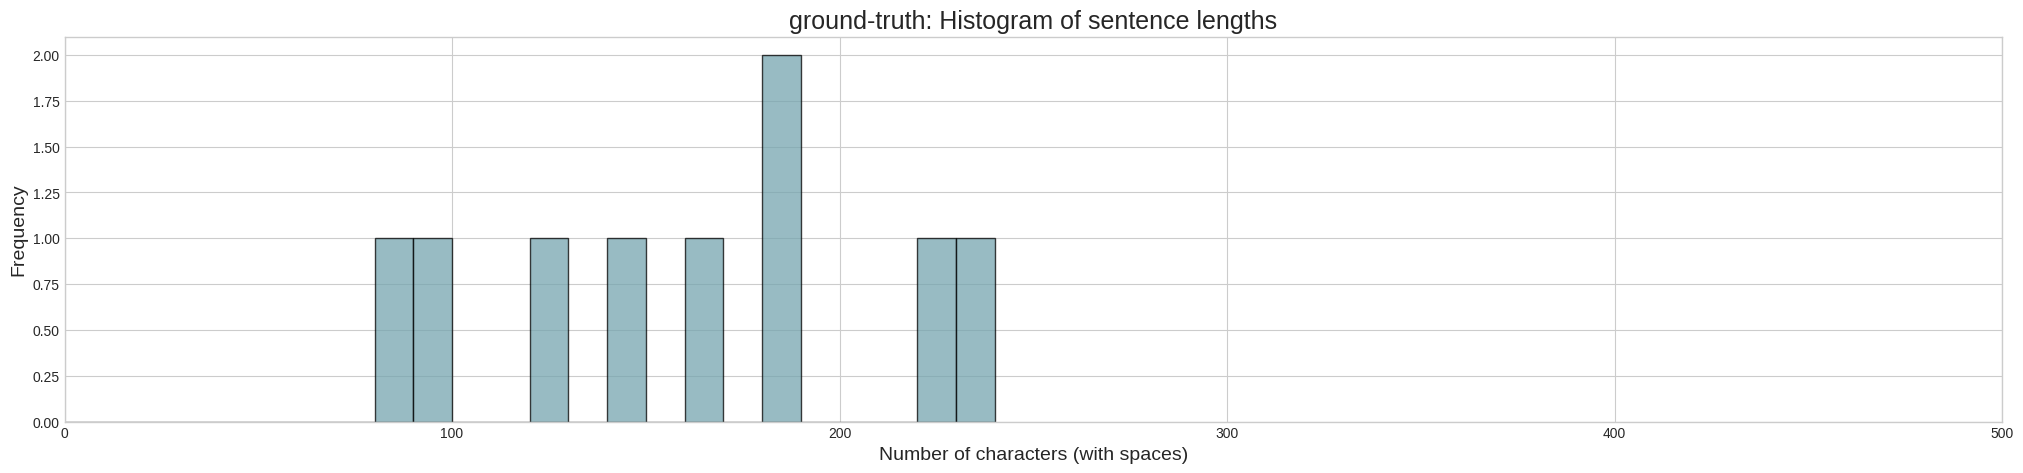

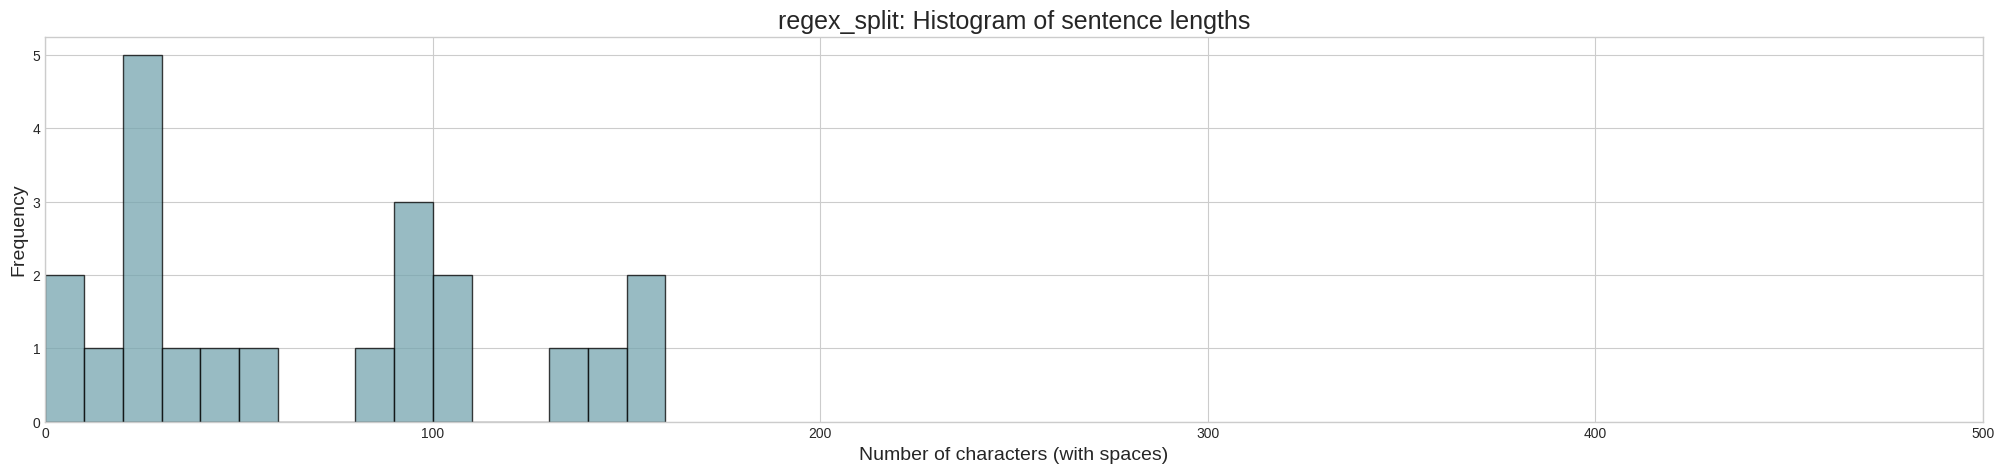

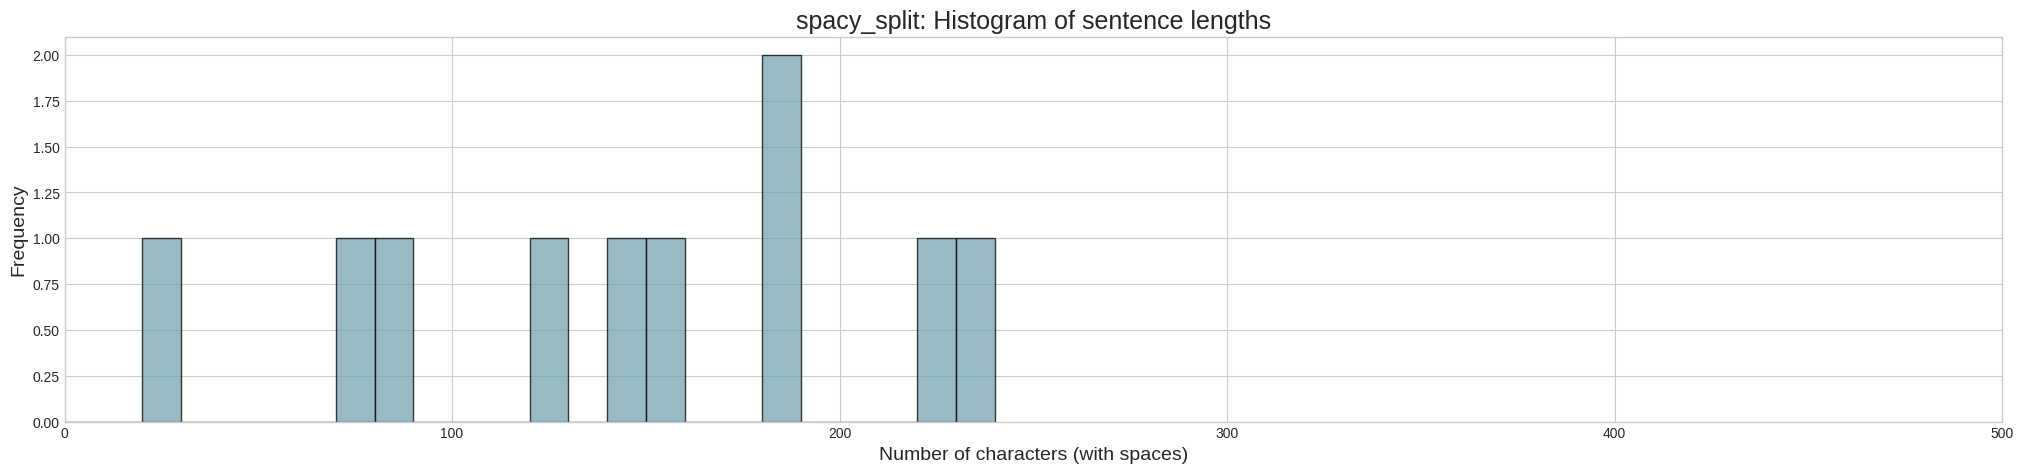

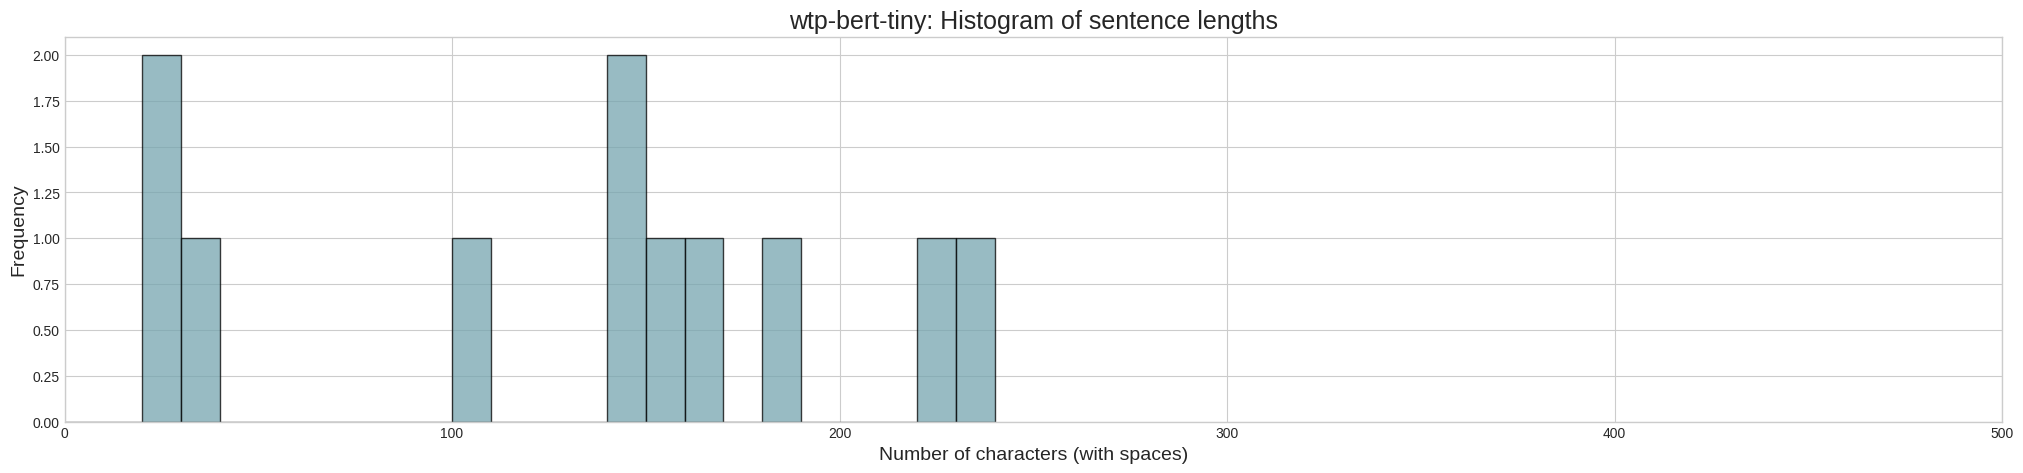

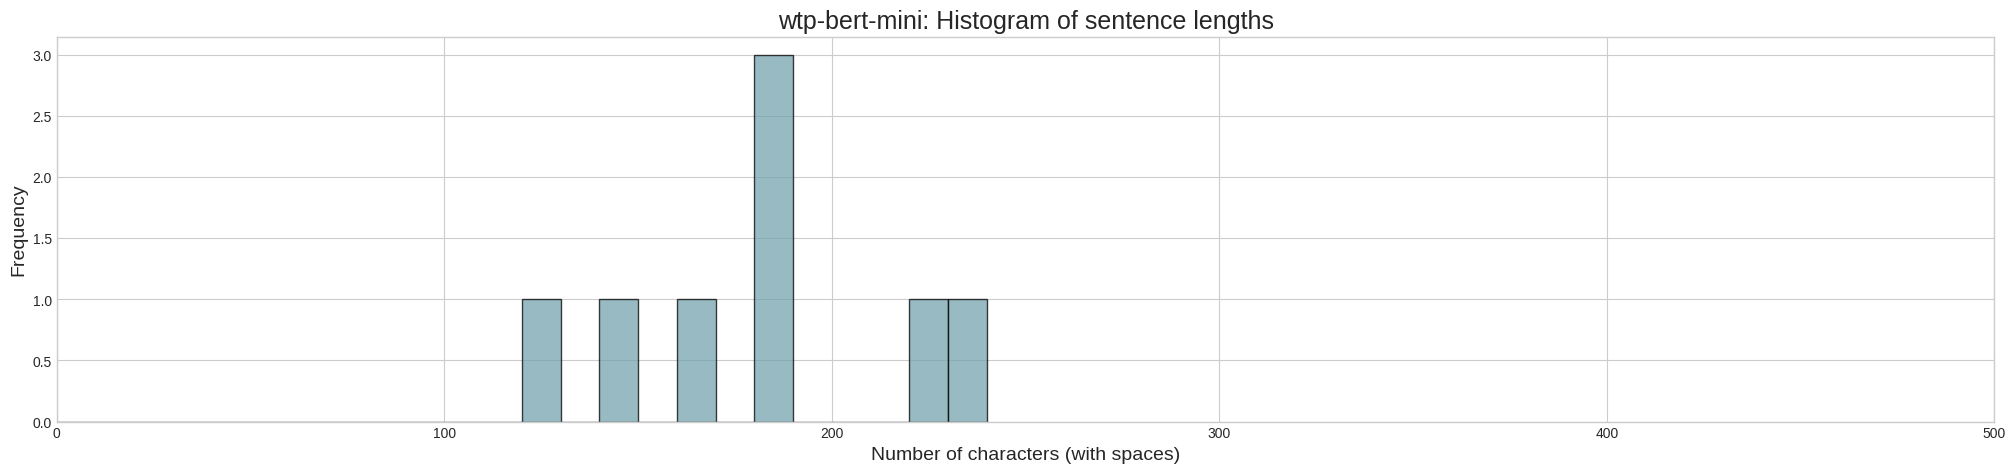

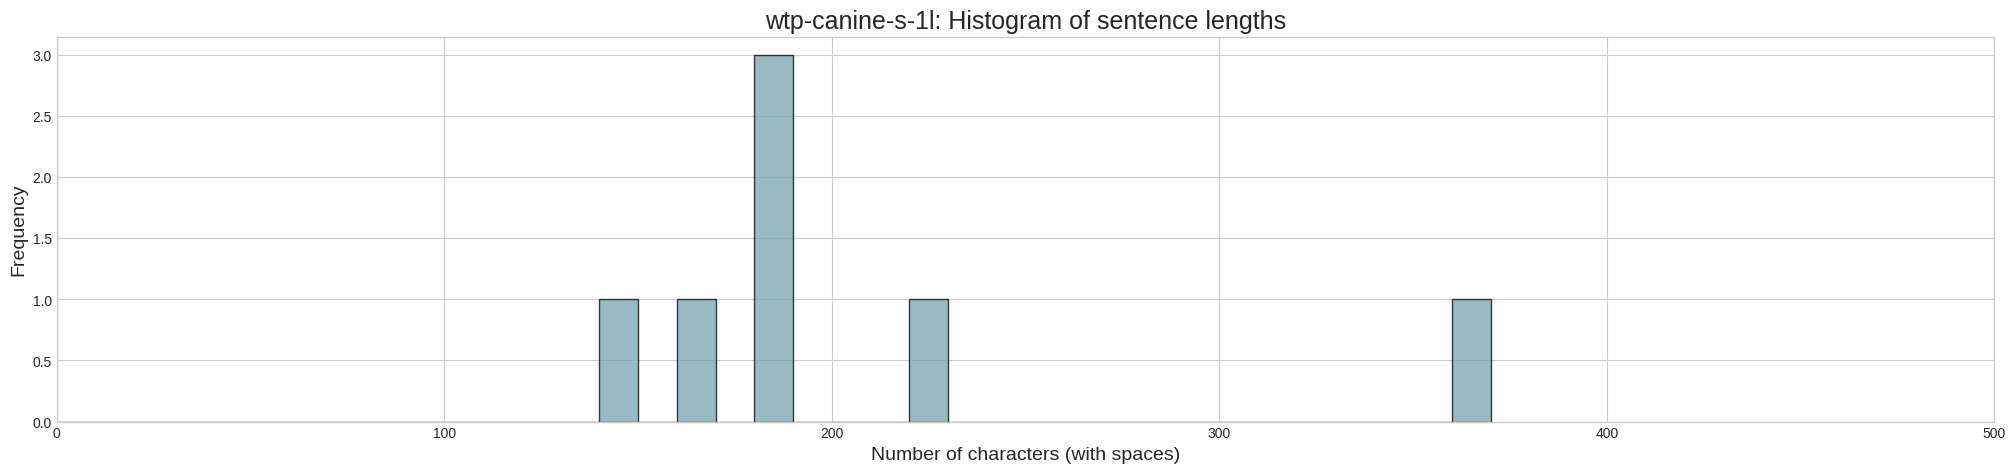

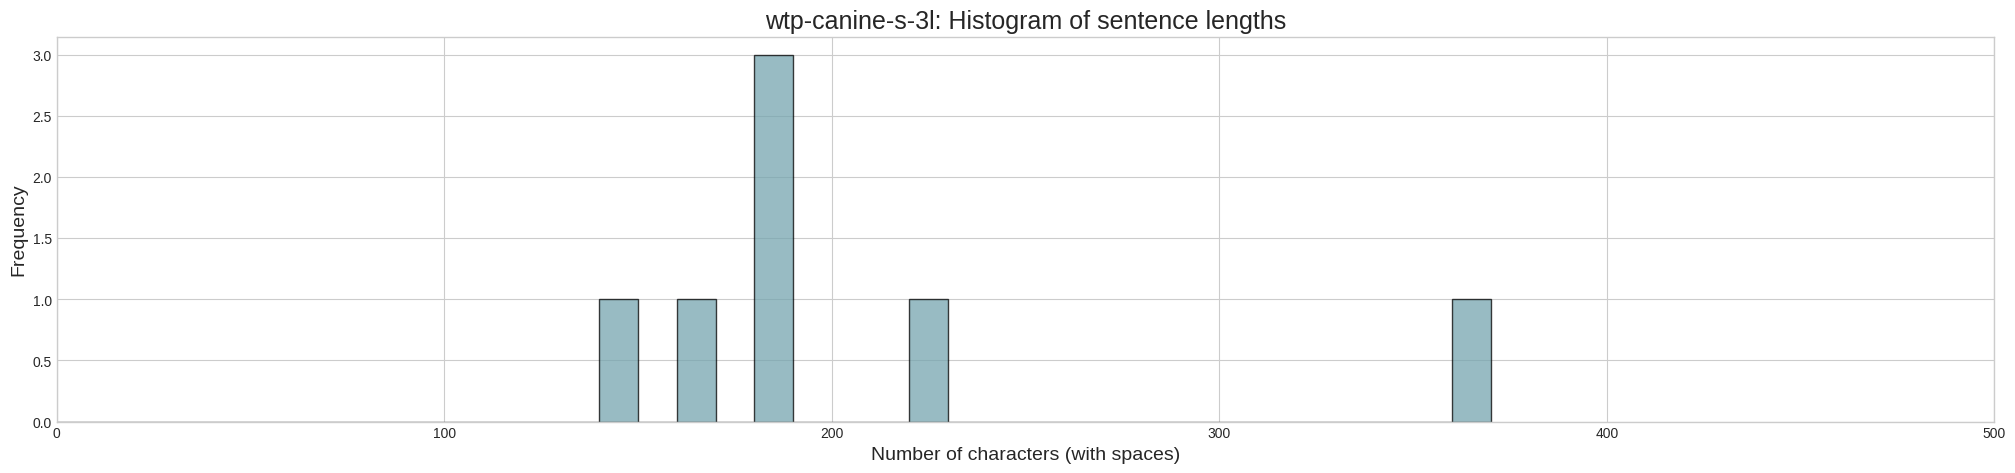

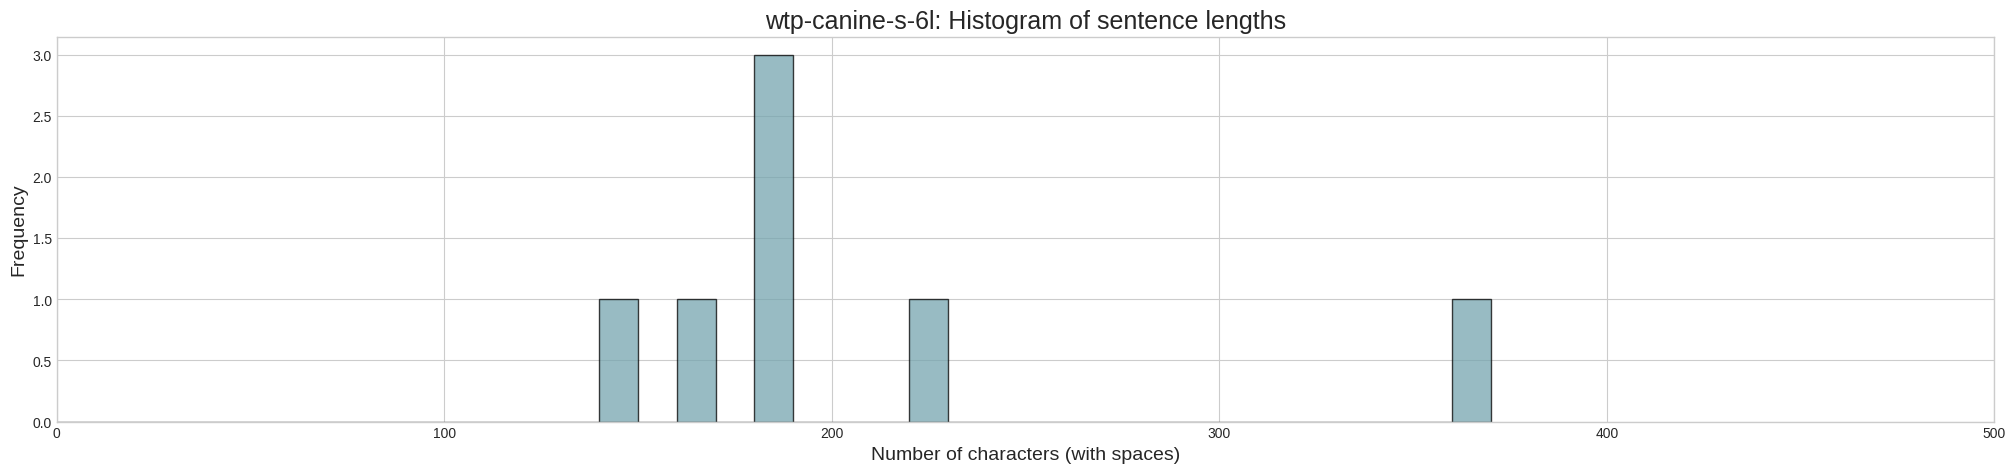

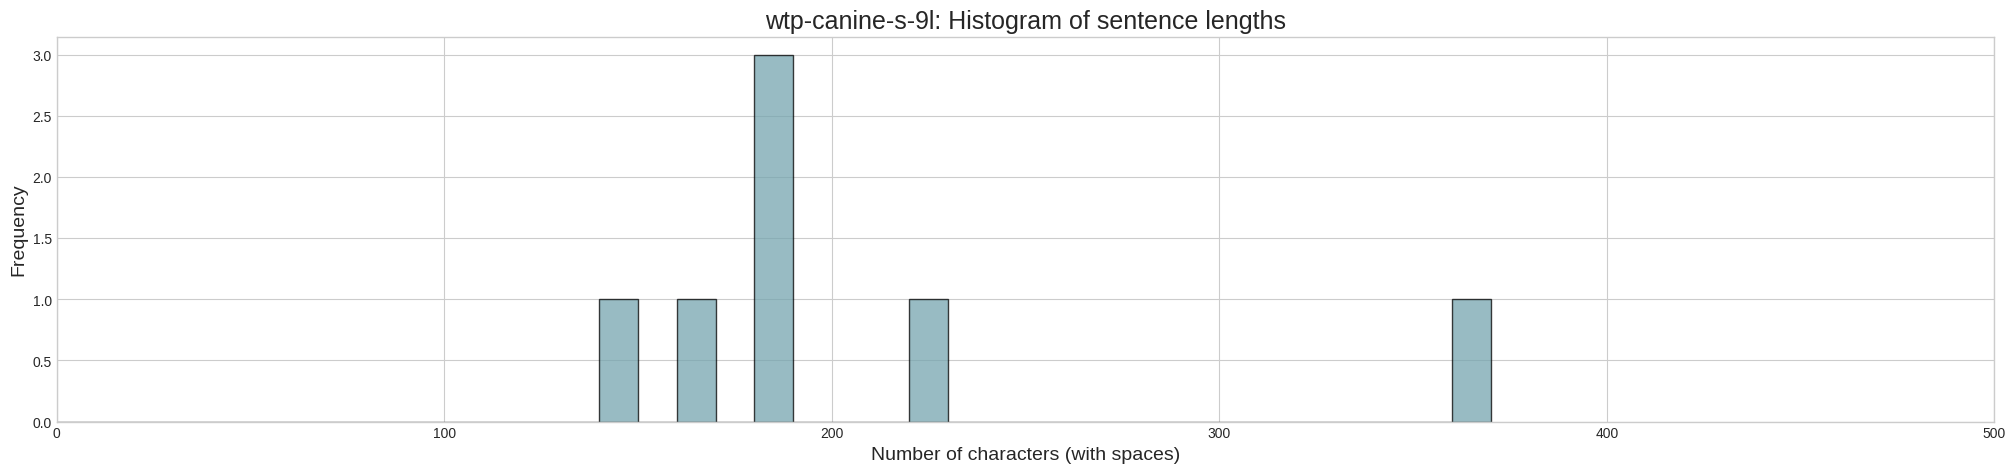

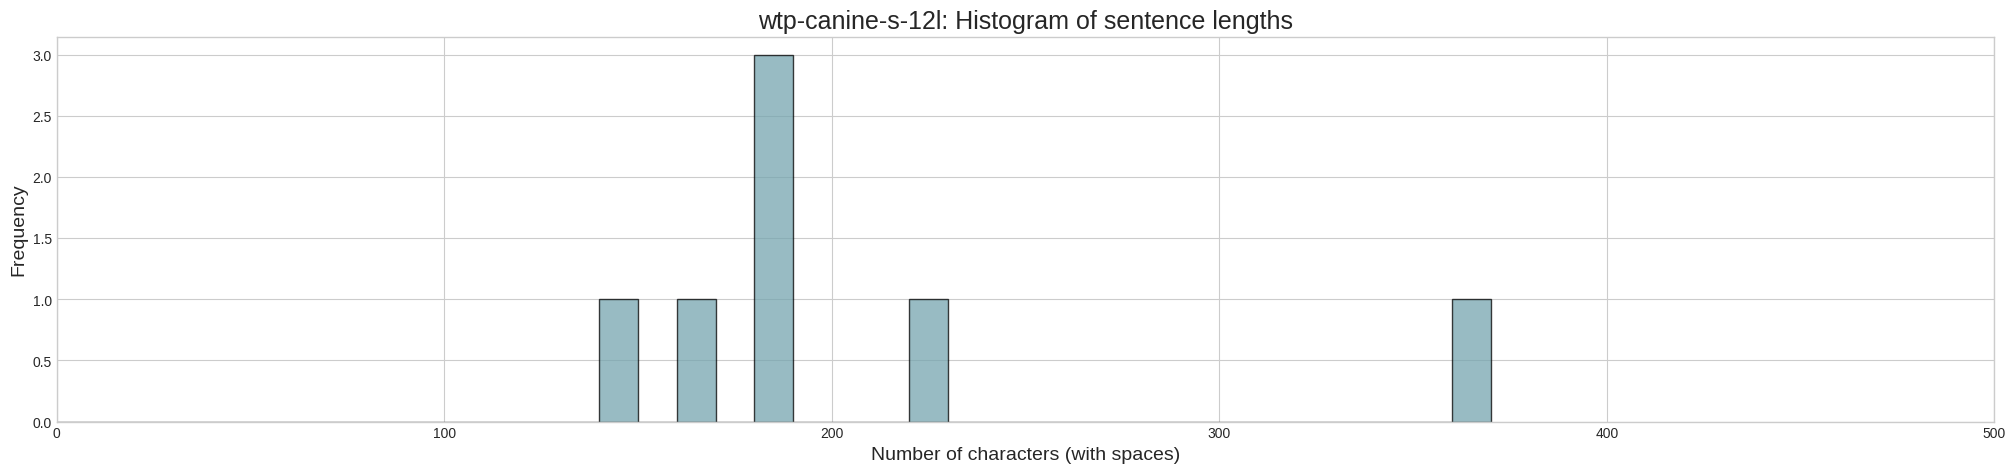

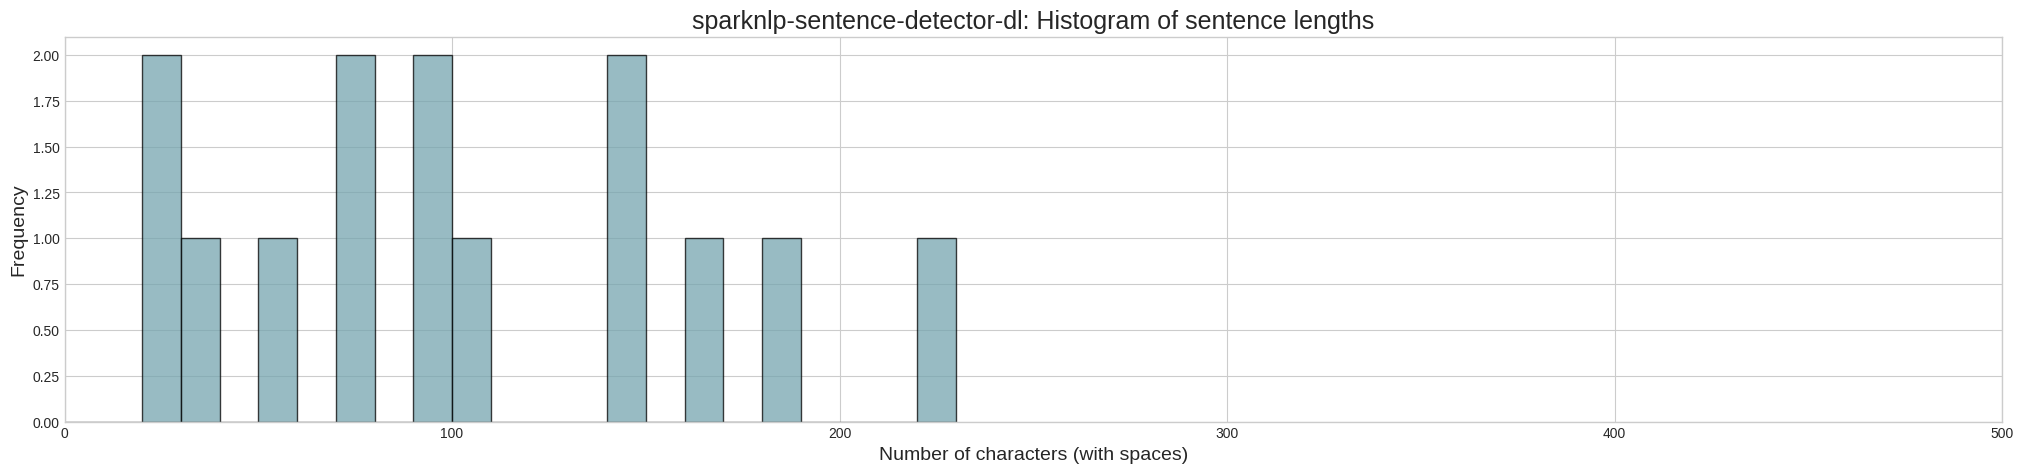

In [22]:
def histogram_sentence_lengths(sentences_dict, xmin, xmax):
    model_name = sentences_dict["model_name"]
    sentences = sentences_dict["sentences"]

    lengths = [len(text) for text in sentences]

    plt.figure(figsize=(25, 5))

    n, bins, patches = plt.hist(lengths, bins=range(0, max(lengths)+10, 10), edgecolor='black', alpha=0.75)

    color = '#76a5af'
    for patch in patches:
        patch.set_facecolor(color)

    plt.title(f'{model_name}: Histogram of sentence lengths', fontsize=18)
    plt.xlabel('Number of characters (with spaces)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlim(xmin, xmax)
    plt.show()


for document_sentences in document_sentences_per_model:
  histogram_sentence_lengths(document_sentences, xmin=0, xmax=500)

## Calculate scores

In [23]:
scores = []

for doc, exec_time in zip(document_sentences_per_model, exec_times):
    metrics = Metrics(ground_truth_sentences, doc["sentences"])
    sent_qty, avg_setn_leng, min_sent_leng, max_sent_leng = metrics.get_sentence_length_statistics()
    windowdiff_score = metrics.get_windowdiff()
    pk_score = metrics.get_pk_score()
    SBERT_avg_cosine_similarity, SBERT_min_cosine_similarity, SBERT_max_cosine_similarity = metrics.get_SBERT_cosine_similarities()
    overlap_coefficient = metrics.get_overlap_coefficient()
    exact_match_ratio = metrics. get_exact_match_ratio()
    scores.append({
            "model_name": doc["model_name"],
            "execution_time": round(exec_time["exec_time"],2),
            "number_of_sentences": sent_qty,
            "average_sentence_length": round(avg_setn_leng,2),
            "minimum_sentence_length": min_sent_leng,
            "maximum_sentence_length": max_sent_leng,
            "windowdiff": round(windowdiff_score,2),
            "pk_score": round(pk_score,2),
            "SBERT_avg_cosine_similarity": round(SBERT_avg_cosine_similarity,2),
            "SBERT_max_cosine_similarity": round(SBERT_max_cosine_similarity,2),
            "overlap_coefficient": round(overlap_coefficient,2),
            "exact_match_ratio": round(exact_match_ratio,2)
    })


df = pd.DataFrame(scores)
df.head(20)

,model_name,execution_time,number_of_sentences,average_sentence_length,minimum_sentence_length,maximum_sentence_length,windowdiff,pk_score,SBERT_avg_cosine_similarity,SBERT_max_cosine_similarity,overlap_coefficient,exact_match_ratio
0,ground-truth,0.00,9,160.67,84,239,0.00,0.00,1.00,1.00,1.00,1.00
1,regex_split,0.00,21,68.52,6,153,0.03,0.02,0.32,0.77,0.19,0.00
2,spacy_split,0.07,10,145.10,29,239,0.01,0.01,0.73,1.00,0.66,0.10
3,wtp-bert-tiny,3.22,11,131.73,22,239,0.01,0.01,0.61,1.00,0.48,0.09
4,wtp-bert-mini,1.53,8,181.50,123,239,0.01,0.00,0.86,1.00,0.82,0.22
5,wtp-canine-s-1l,2.58,7,207.57,146,363,0.01,0.01,0.74,1.00,0.62,0.11
6,wtp-canine-s-3l,3.22,7,207.57,146,363,0.01,0.01,0.74,1.00,0.62,0.11
7,wtp-canine-s-6l,3.54,7,207.57,146,363,0.01,0.01,0.74,1.00,0.62,0.11
8,wtp-canine-s-9l,4.49,7,207.57,146,363,0.01,0.01,0.74,1.00,0.62,0.11
9,wtp-canine-s-12l,5.03,7,207.57,146,363,0.01,0.01,0.74,1.00,0.62,0.11


In [24]:
raw_text5 = raw_text+raw_text+raw_text+raw_text+raw_text
raw_text10 = raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text
raw_text15 = raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text
raw_text20 = raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text
raw_text25 = raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text+raw_text

In [25]:
def calculate_exec_times(rt, i):
  exec_times = []

  # 1. Regex-based sentence segmentation
  start_time = time.time()

  regex_split_sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', rt)

  end_time = time.time()
  execution_time = end_time - start_time

  exec_times.append({"model_name": "regex_split", "exec_time": execution_time, "order": i})

  # 2. spaCy-ased sentence segmentation
  start_time = time.time()

  doc = nlp(rt)

  spacy_split_sentences = [sentence.text for sentence in doc.sents]

  end_time = time.time()
  execution_time = end_time - start_time

  exec_times.append({"model_name": "spaCy_split", "exec_time": execution_time, "order": i})

  # 3. WtP-ased sentence segmentation

  models = ["wtp-bert-tiny","wtp-bert-mini","wtp-canine-s-1l","wtp-canine-s-3l","wtp-canine-s-6l","wtp-canine-s-9l","wtp-canine-s-12l"]

  for model in models:
    try:
      start_time = time.time()

      wtp = WtP(model)
      document_sentences_tmp = wtp.split(rt, lang_code="en", style="ud", threshold=0.7)

      end_time = time.time()
      execution_time = end_time - start_time

      exec_times.append({"model_name": model, "exec_time": execution_time, "order": i})
    except:
        pass

  # 4. SparkNLP-based sentence segmentation
  start_time = time.time()

  sparknlp_sentences = []
  for anno in sd_model.fullAnnotate(rt)[0]["sentences"]:
      sparknlp_sentences.append(anno.result)

  end_time = time.time()
  execution_time = end_time - start_time

  exec_times.append({"model_name": "sparknlp-sentence-detector-dl", "exec_time": execution_time, "order": i})

  return exec_times

In [ ]:
exec_times_statistics = []

i = 0
for rt in [raw_text, raw_text5, raw_text10, raw_text15, raw_text20, raw_text25]:
  exec_times_statistics.append(calculate_exec_times(rt, i))
  i = i + 5

In [ ]:
exec_times_statistics

In [ ]:
flat_data = sorted([item for sublist in exec_times_statistics for item in sublist], key=lambda x: (x["model_name"], x["order"]))

model_data = {}
for item in flat_data:
    if item["model_name"] not in model_data:
        model_data[item["model_name"]] = {"exec_times": [], "orders": []}
    model_data[item["model_name"]]["exec_times"].append(item["exec_time"])
    model_data[item["model_name"]]["orders"].append(item["order"])

model_names = list(model_data.keys())
colors = plt.cm.jet(np.linspace(0, 1, len(model_names)))
model_to_color = dict(zip(model_names, colors))

fig, ax = plt.subplots(figsize=(15, 7))

for model_name, data in model_data.items():
    ax.plot(data["orders"], data["exec_times"], "-o", label=model_name, color=model_to_color[model_name])

unique_orders = sorted(set(item["order"] for item in flat_data))
plt.xticks(unique_orders)

plt.legend(title="Sentence Segmentation Method")

plt.xlabel("Text Volume Scale", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)
plt.title("Execution Time by Text Volume Scale for Different Sentence Segmentation Methods", fontsize=18)

plt.show()